In [9]:
import pandas as pd

Source: https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

In [10]:
df1 = pd.read_csv('data_with_city.csv').iloc[:,4:]

In [11]:
df1.sample(5)

,Datetime,Tweet Id,Text,Username,Hashtags,Like(s),Reply(s),Retweet(s),Search term,Coordinates,Latitude,Longitude,city,country
4820,2022-03-14 21:53:56+00:00,1503489631307898885,Is the #Russia invasion of #Ukraine a #Trojan ...,swepal2,"['Russia', 'Ukraine', 'Trojan', 'financial', '...",0,0,0,Russia,"Coordinates(longitude=17.7601322, latitude=59....",59.227138,17.760132,Ronninge,SE
7794,2022-03-02 03:18:23+00:00,1498860240439164931,"Dear Friends in Singapore and New Zealand, \ny...",UKRinSGP,NaN,3,0,1,Ukraine,"Coordinates(longitude=103.749959507073, latitu...",1.212314,103.749960,Singapore,SG
11252,2022-02-27 11:57:55+00:00,1497903820969586696,"@Mariia_Zolkina @kennethrohde @NATO Well, they...",codepo8,NaN,7,0,0,NATO,"Coordinates(longitude=13.088304, latitude=52.3...",52.338079,13.088304,Michendorf,DE
8182,2022-03-03 18:05:09+00:00,1499445790372245511,Putin's regime is a criminal organisation.\n\n...,AdrianFarrellAT,"['ToryCorruption', 'ToryRussianAssets', 'ToryR...",3,0,1,Ukraine,"Coordinates(longitude=-0.2925791, latitude=51....",51.555179,-0.292579,Wembley,GB
1512,2022-02-28 04:00:51+00:00,1498146153296056327,There is no doubt that Russia has committed an...,lhsingapura,NaN,2,0,0,Russia,"Coordinates(longitude=103.749959507073, latitu...",1.212314,103.749960,Singapore,SG


## 0.preprocess

In [12]:
import re
import nltk
def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text
df1['cleaned'] = df1['Text'].apply(clean)
from tqdm.notebook import tqdm
tqdm.pandas()

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df1['tagged'] = df1['cleaned'].progress_apply(token_stop_pos)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df1['lemma'] = df1['tagged'].progress_apply(lemmatize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 1. Use Textblob

In [13]:
from textblob import TextBlob

$subjectivity \in [0:1]: 0=neutral, 1=opinioned$ <br/>
$polarity \in [-1:1]: -1=negative, 1=positive$

In [14]:
df1['textblob_subjectivity'] = df1['Text'].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
df1['textblob_polarity'] = df1['Text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 2. Use VADER

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [16]:
df1['vader_pos'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['pos'])
df1['vader_neu'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['neu'])
df1['vader_neg'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['neg'])
df1['vader_polarity'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['compound'])

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 3. Use SentiWordNet

In [17]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Junlong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
def sentiwordnetanalysis(pos_data):
    pos_score,neg_score=0,0
    total_tokens = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        total_tokens+=1
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        pos_score+= swn_synset.pos_score()
        neg_score+= swn_synset.neg_score()
    if total_tokens==0:
        return 0,0
    return pos_score/total_tokens,neg_score/total_tokens


In [19]:
df1['swn_pos'] = df1['tagged'].progress_apply(lambda x: sentiwordnetanalysis(x)[0])
df1['swn_neg'] = df1['tagged'].progress_apply(lambda x: sentiwordnetanalysis(x)[1])
df1['swn'] = df1['swn_pos']-df1['swn_neg']

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

In [20]:
df1.sample(5)

,Datetime,Tweet Id,Text,Username,Hashtags,Like(s),Reply(s),Retweet(s),Search term,Coordinates,...,lemma,textblob_subjectivity,textblob_polarity,vader_pos,vader_neu,vader_neg,vader_polarity,swn_pos,swn_neg,swn
6199,2022-02-26 21:54:52+00:00,1497691662805524483,"Used to date Asian tech billionaires, now home...",angelina,NaN,2,0,0,Ukraine,"Coordinates(longitude=13.088304, latitude=52.3...",...,Used date Asian tech billionaire homeless Eu...,0.628571,-0.171429,0.136,0.674,0.189,-0.5106,0.059524,0.053571,0.005952
6121,2022-02-26 04:37:38+00:00,1497430633873821696,Reportage: Police suppress second day of Mosco...,Dzemalion,"['againstwar', 'documentary', 'nowarinukraine'...",1,0,0,Ukraine,"Coordinates(longitude=36.8878157, latitude=55....",...,Reportage Police suppress second day Moscow ...,0.000000,0.000000,0.000,0.905,0.095,-0.2263,0.000000,0.000000,0.000000
12077,2022-03-13 17:14:58+00:00,1503057042231209989,"It's time to call Putin's bluff @NATO, or are ...",rustyrude1,NaN,0,0,0,NATO,"Coordinates(longitude=-0.008924, latitude=51.4...",...,time call Putin bluff NATO paper tiger,0.000000,0.000000,0.000,1.000,0.000,0.0000,0.035714,0.000000,0.035714
54,2022-02-24 13:03:46+00:00,1496833231425249284,Yea that’s how to get the world on your side R...,phx787,NaN,0,0,0,Russia,"Coordinates(longitude=139.695191, latitude=35....",...,Yea get world side Russia http co GSomLxWkNI,0.000000,0.000000,0.000,1.000,0.000,0.0000,0.053571,0.000000,0.053571
6946,2022-02-27 16:54:07+00:00,1497978364304535554,So only Ukrainian passport holders are fleeing...,expensivestevie,NaN,0,0,0,Ukraine,"Coordinates(longitude=24.746446, latitude=60.2...",...,Ukrainian passport holder flee Ukraine Class...,0.583333,0.104167,0.000,1.000,0.000,0.0000,0.083333,0.000000,0.083333


In [21]:
df1.to_csv('df1.csv')

## 4. Some Visualizations

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

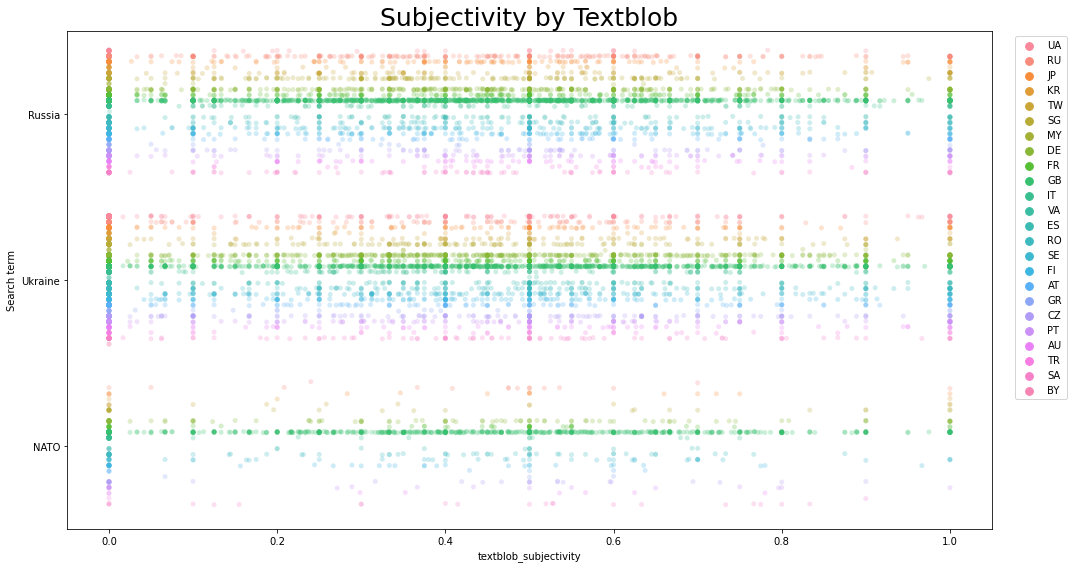

In [23]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="textblob_subjectivity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Subjectivity by Textblob',size=25)
plt.tight_layout()
plt.show()

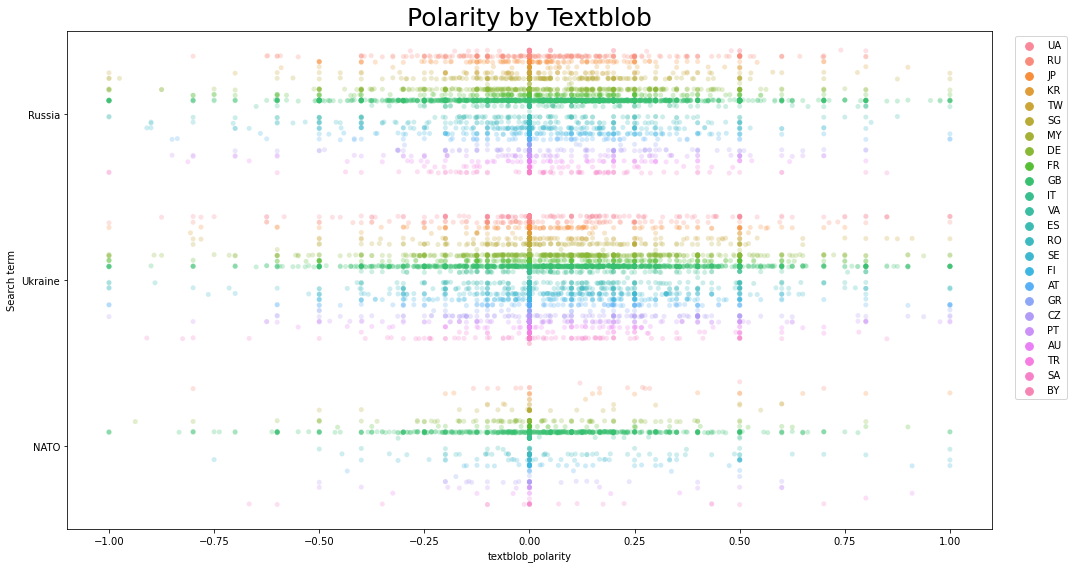

In [24]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="textblob_polarity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by Textblob',size=25)
plt.tight_layout()
plt.show()

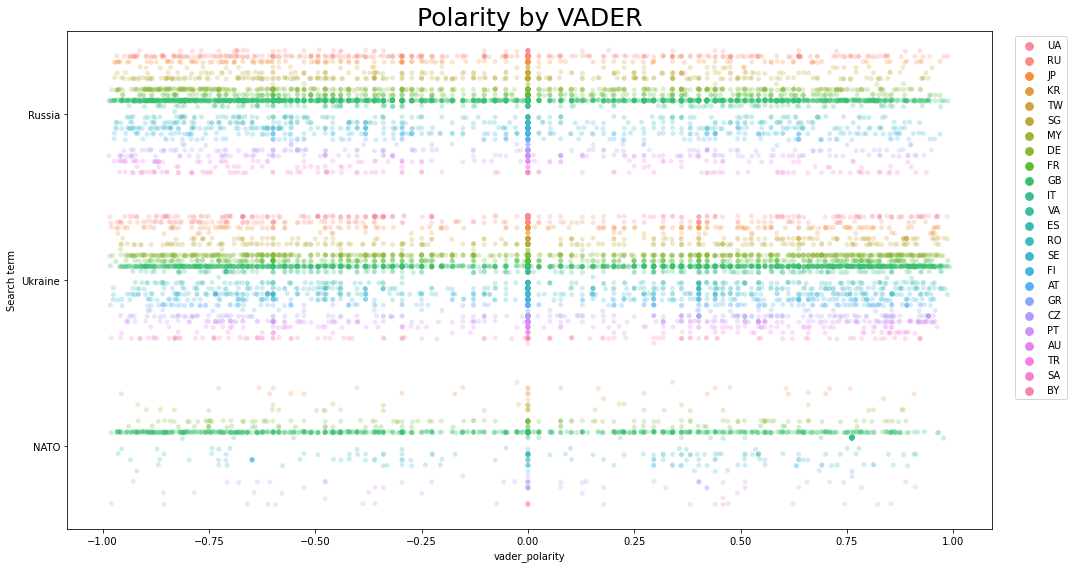

In [25]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="vader_polarity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by VADER',size=25)
plt.tight_layout()
plt.show()

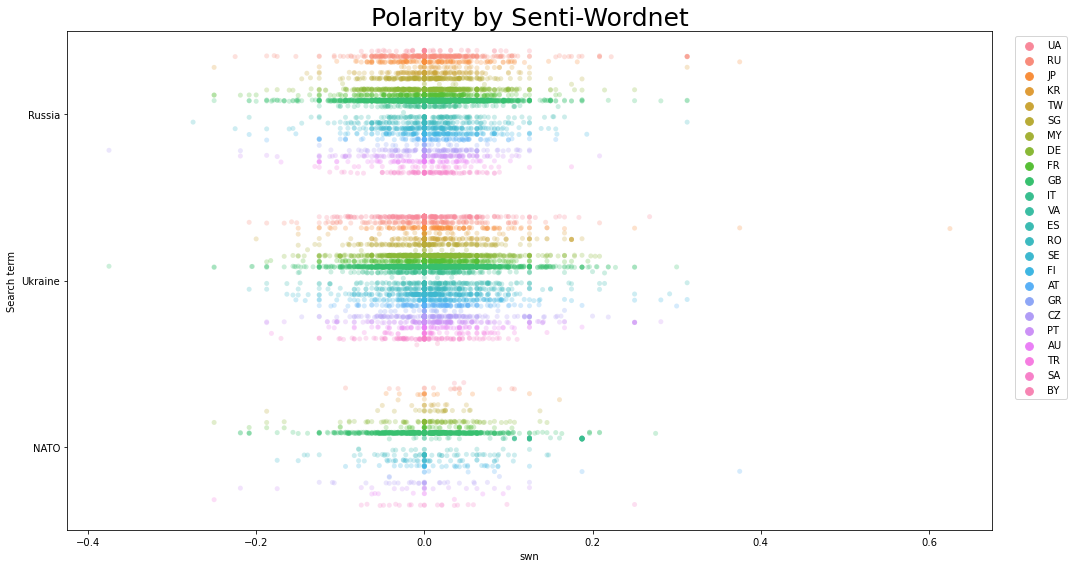

In [26]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="swn", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by Senti-Wordnet',size=25)
plt.tight_layout()
plt.show()

In [27]:
df1 = pd.read_csv('df1.csv')
df1.keys()

Index(['Unnamed: 0', 'Datetime', 'Tweet Id', 'Text', 'Username', 'Hashtags',
       'Like(s)', 'Reply(s)', 'Retweet(s)', 'Search term', 'Coordinates',
       'Latitude', 'Longitude', 'city', 'country', 'cleaned', 'tagged',
       'lemma', 'textblob_subjectivity', 'textblob_polarity', 'vader_pos',
       'vader_neu', 'vader_neg', 'vader_polarity', 'swn_pos', 'swn_neg',
       'swn'],
      dtype='object')

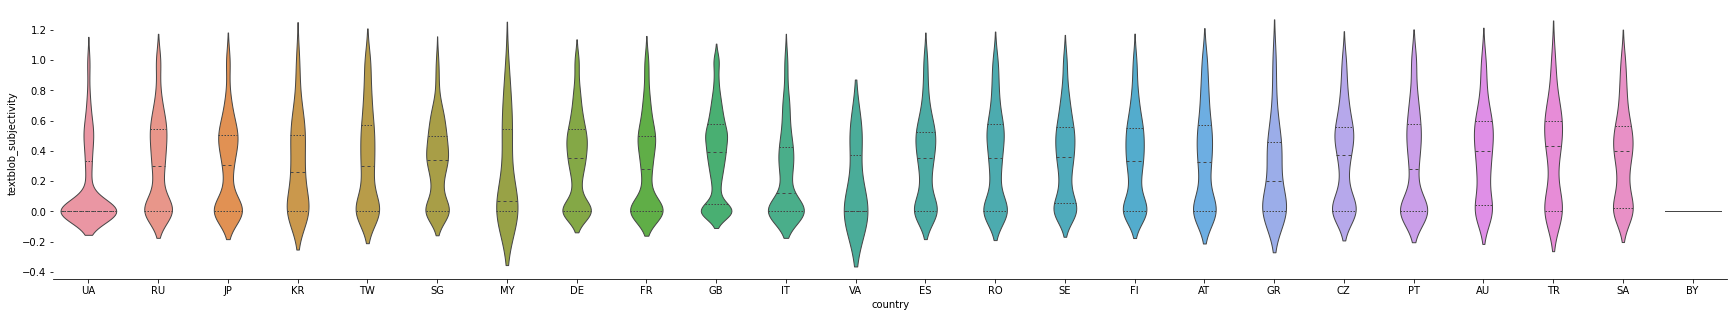

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="textblob_subjectivity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

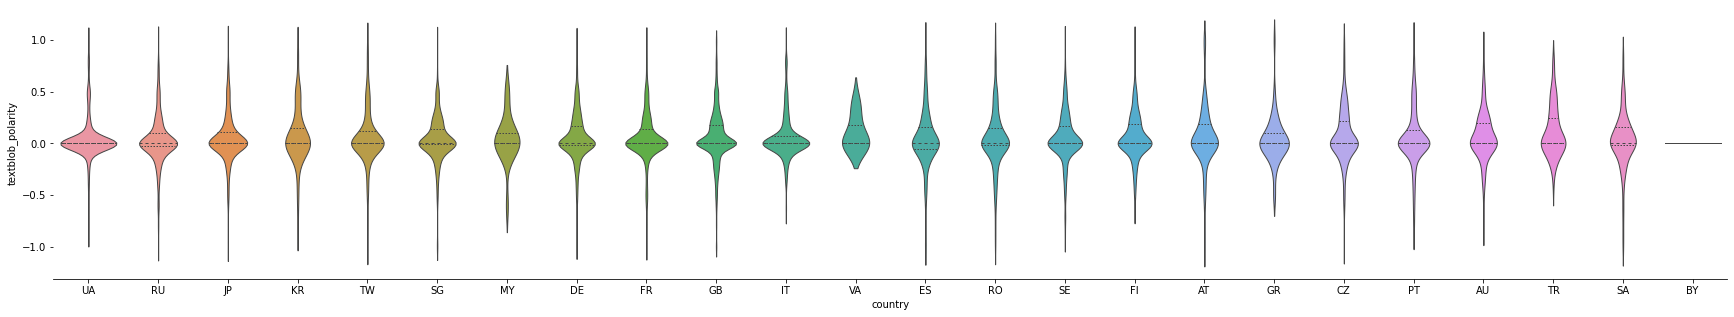

In [29]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="textblob_polarity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

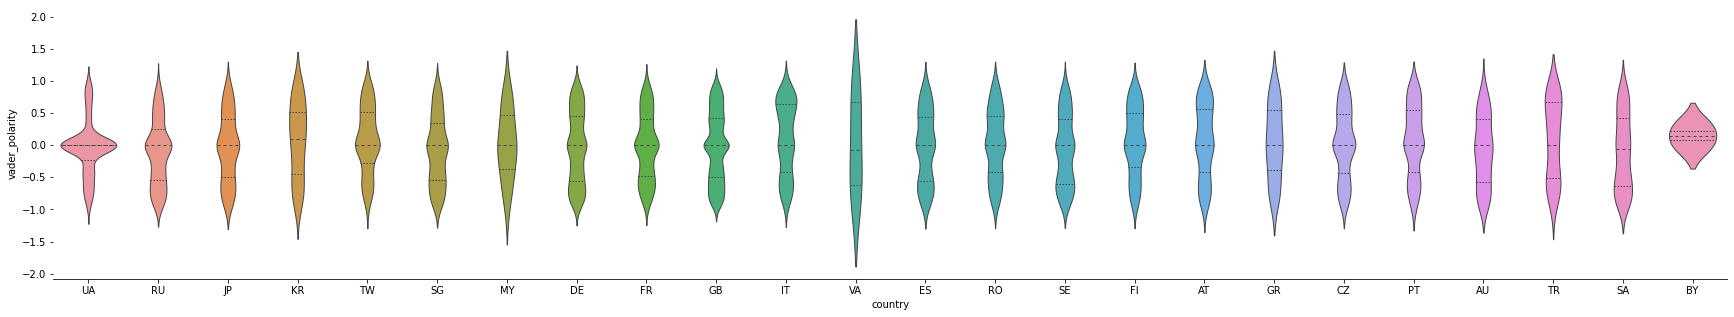

In [30]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="vader_polarity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

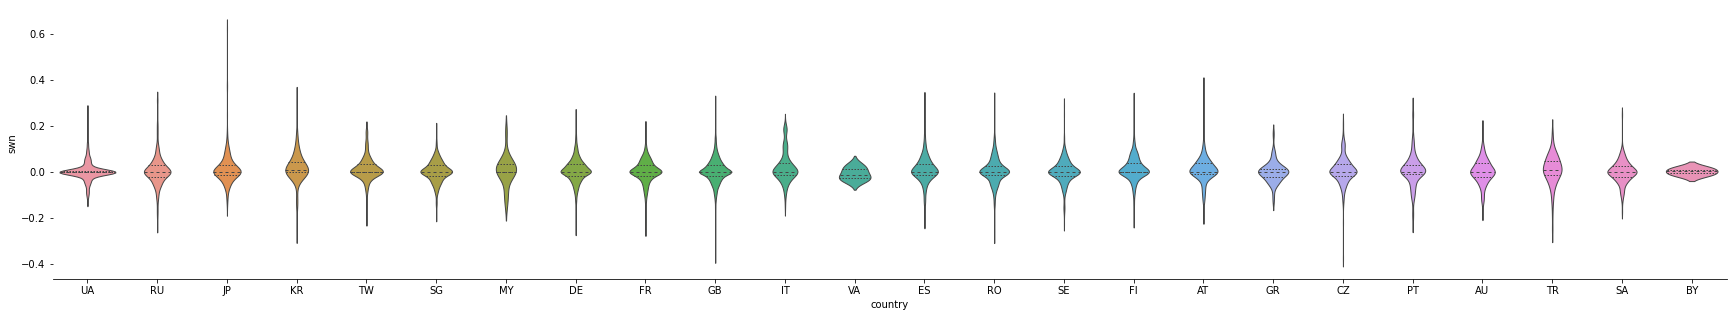

In [31]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="swn",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

In [32]:
d2 = pd.DataFrame()

In [41]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').textblob_polarity.mean()
tb = dict(textblob_polarity)
l0 = [(tb[k],k) for k in tb]
l0.sort()
l0 = l0[::-1]
l0
rank_t = dict(zip([x[1] for x in l0],list(range(len(l0)))))

In [42]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').vader_polarity.mean()
tb = dict(textblob_polarity)
l1 = [(tb[k],k) for k in tb]
l1.sort()
l1 = l1[::-1]
l1
rank_v = dict(zip([x[1] for x in l1],list(range(len(l0)))))

In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').swn.mean()
tb = dict(textblob_polarity)
l2 = [(tb[k],k) for k in tb]
l2.sort()
l2 = l2[::-1]
l2
rank_s = dict(zip([x[1] for x in l2],list(range(len(l0)))))

In [44]:
len(l0),len(l1),len(l2)

(24, 24, 24)

In [38]:
polarity_rank = pd.DataFrame({
    'textblob':rank_t,
    'vader':rank_v,
    'swn':rank_s
})
polarity_rank

,textblob,vader,swn
TR,0,2,7
VA,1,12,23
CZ,2,9,8
AU,3,20,15
KR,4,4,1
FI,5,7,2
TW,6,3,3
AT,7,6,5
IT,8,1,0
GB,9,15,13


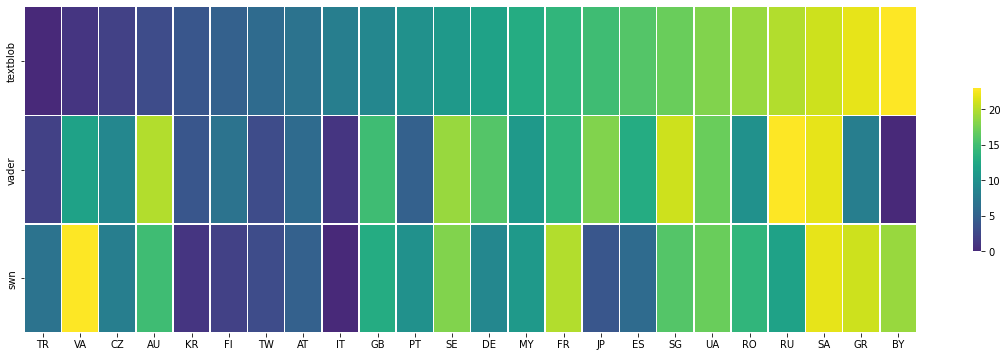

In [45]:
# Generate a custom diverging colormap
cmap = sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(20,6))
sns.heatmap(polarity_rank.T, cmap=cmap, center=10,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heat.svg')